In [1]:
# Зададим стили
from IPython.display import HTML
with open('./styles/overall.css', 'r') as stl:
    style = stl.read()
HTML(style)

In [2]:
# Графические утилитки
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

In [3]:
# Библиотеки для работы с данными
import pandas as pd
import pickle
from os.path import exists
from itertools import chain
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
import scipy
from src.utils import (build_models,
                       get_best_model,
                       exponential_smoothing,
                       stable_seasoal_filter,
                       smn_seasonal_filter,
                       prepare_data,
                       subtract
                      )
from src.tests import (dickey_fuller_test,
                       ljung_box_test,
                       kpss_test,
                       jarque_bera_test,
                       likelyhood_ratio_test,
                       print_test_results
                      )

In [4]:
# Магия для управления предупреждениями
from warnings import filterwarnings

In [5]:
# Импорт данных
from src.data import (temperatures,
                      beer,
                      )

In [6]:
# Настройка графической утилиты
width = 15
height = 8
plt.rcParams['figure.figsize'] = (width, height)
plt.rcParams['axes.titlesize'] = 25

# Настройки отображения
line_width = 1
dot_size = 5

In [7]:
data_temp = prepare_data(temperatures, value_col='Temp')
data_beer = prepare_data(beer, date_col='date', value_col='value')

![Logo](img/mephi-logo.png)

<h1>Сезонность</h1><br>
<span class="text_common"><b>Определение: <i>сезонностью временного ряда</i></b> называют наблюдаемые в нём периодические колебания.<br>
Рассмотрим пример временного ряда, показывающего ежедневные значения минимальной температуры воздуха в Австралии.</span>

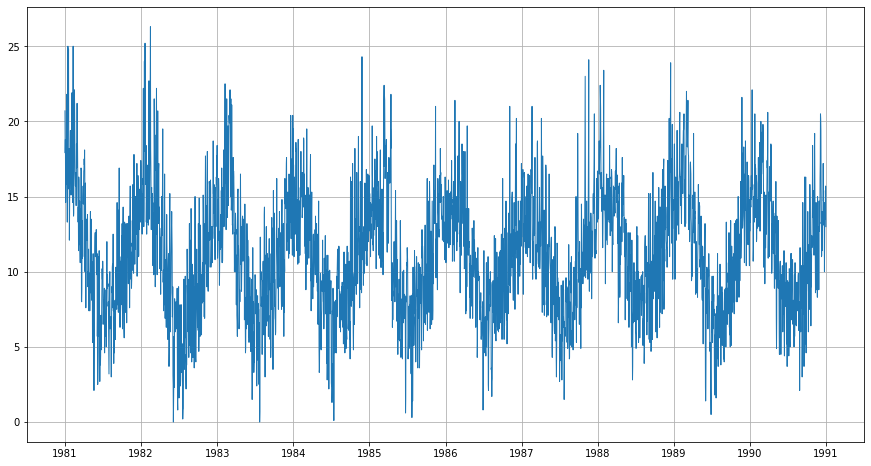

In [8]:
plt.plot(data_temp, linewidth=line_width)
plt.grid()

<span class="text_common">Данный ряд не имеет выраженной трендовой составляющей, поэтому будем рассматривать выделение сезонности для этого ряда в том ключе, как будто тренд из него исключен. Для центрирования графика на 0 вычтем из него его линейный тренд.</span>
<h2>Выделение сезонной составляющей</h2>
<h3>seasonal_decompose</h3>

In [9]:
# Для выделения сезонной составляющей можно воспользоваться функцией seasonal_decompose из пакета statsmodels
decomposition = seasonal_decompose(data_temp, model='additive', period=365)

In [10]:
temp_dt = subtract(data_temp, decomposition.trend).dropna()

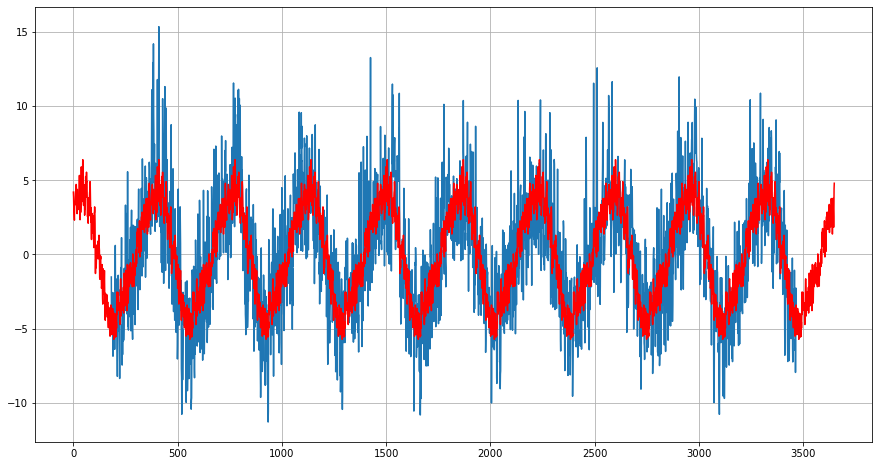

In [11]:
plt.plot(temp_dt)
plt.plot(decomposition.seasonal.values, c='r')
plt.grid()

<span class="text_common"><b>Основные выводы:</b> тренд достаточно хорошо выделяется функцией. При этом, как потом будет показано, используется стабильный сезонный фильтр.</span>

<h3>EWMA фильтр</h3><br>
<span class="text_common">EWMA (exponentially weighted moving average) математически выражается следующим образом:</span>
$$
{\large z_t = \alpha Y_t + (1 - \alpha) z_{t-1}, \ \alpha \in [0, 1] }
$$

In [12]:
ewma_seasonality = exponential_smoothing(temp_dt, alpha=0.05)

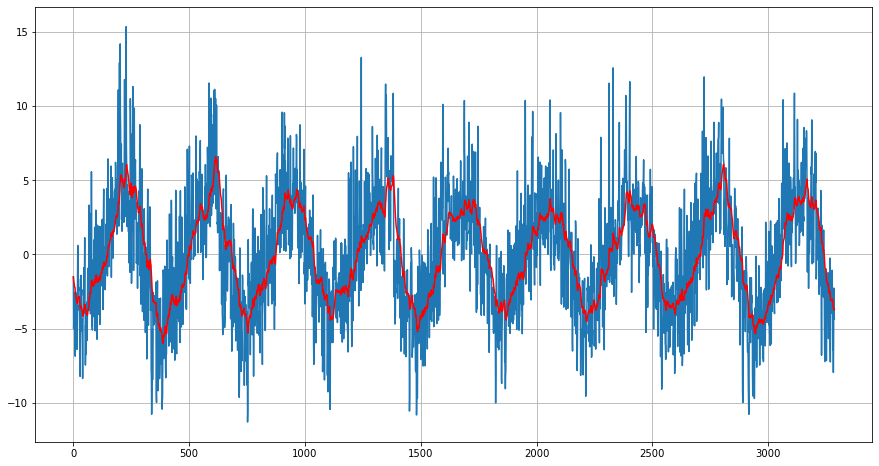

In [13]:
plt.plot(temp_dt.values)
plt.plot(ewma_seasonality, c='r')
plt.grid()

<span class="text_common"><b>Основные выводы:</b> модель экспоненциального взвешенного скользящего среднего также хорошо справляется с выделением сезонной составляющей ряда.</span>

<h3>Стабильный сезонный фильтр</h3><br>
<span class="text_common">Стабильный сезонный фильтр представляет собой в сущности усреднённые значения на расстоянии, кратном периоду, от данного. Математически это можно выразить следующим образом:</span>
$$
{\large \tilde{s}_k = \frac{1}{n_k} \sum_{j=0}^{N_\Delta} {y_k + j \Delta}, \ k = \overline{1...\Delta} }
$$
<span class="text_common">На выходе стабильный сезонный фильтр выдаёт следующие значения:</span>
$$
{\large \tilde{s}_1, ..., \tilde{s}_\Delta, \tilde{s}_1, ..., \tilde{s}_\Delta, ..., \tilde{s}_1, ..., \tilde{s}_\Delta}
$$

In [14]:
stable_seasonality = stable_seasoal_filter(temp_dt, 365)

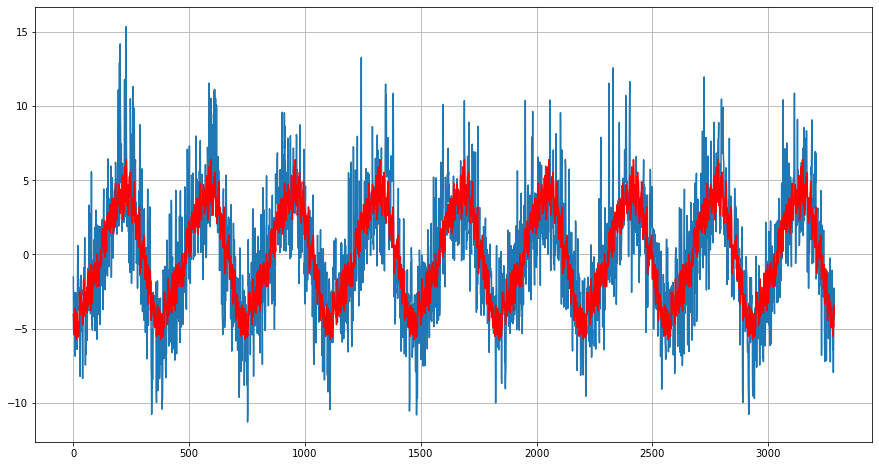

In [15]:
plt.plot(temp_dt.values)
plt.plot(stable_seasonality.values, c='r')
plt.grid()

<span class="text_common"><b>Основные выводы:</b> заметим, что выход стабильного сезонного фильтра на данном временном ряду даёт практически такую же картину, как и <span class="code">seasonal_decompose</span>. В данном случае это ожидаемо ввиду того, что данный ряд не имеет сильных колебаний между сезонными значениями.</span>

### S(m, n) сезонный фильтр

$S_{m \times n}$<span class="text_common"> сезонный фильтр представляет собой n-арное скользящее среднее для m-арных средних. Фактически это эквивалентно центральному скользящему среднему с окном n + m - 1 с разными весами.</span>

In [16]:
smn_seasonality = smn_seasonal_filter(temp_dt, 7, 16)

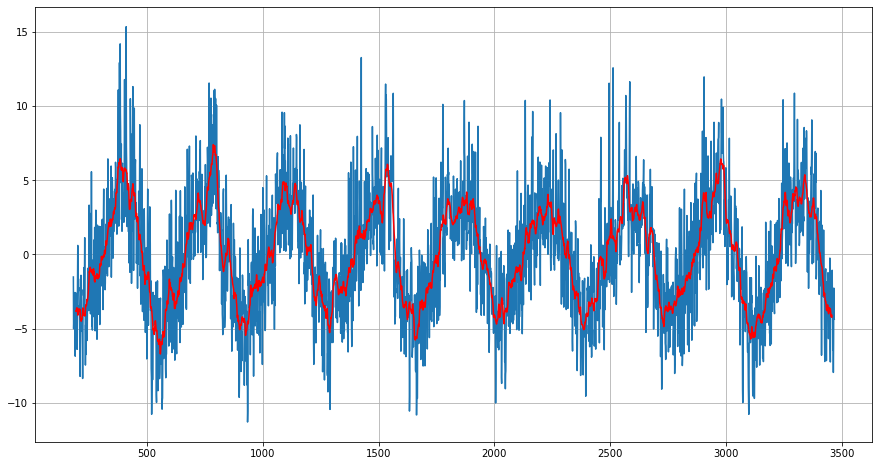

In [17]:
plt.plot(temp_dt)
plt.plot(smn_seasonality, c='r')
plt.grid()

<span class="text_common"><b>Основные выводы:</b> так как S(m, n) фильтр эквивалентен скользящему среднему с окном m + n - 1, то при увеличении m и n сезонная составляющая будет становиться более сглаженной..</span>

<h1>Анализ стохастической компоненты</h1>

In [18]:
# Подготовим данные, оставив только стохастические компоненты в рядах
# Для этого воспользуемся уже знакомой функцией seasonal_decompose
temp_resid = decomposition.resid
beer_resid = seasonal_decompose(data_beer).resid.dropna()

<span class="text_common">Построим графики стохастических компонент выбранных временных рядов.</span>

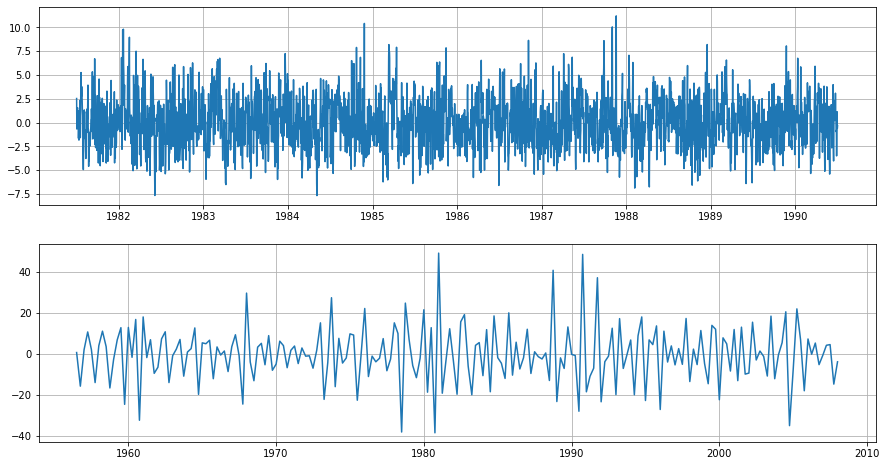

In [19]:
_, ax = plt.subplots(2, 1)
ax[0].plot(temp_resid), ax[0].grid()
ax[1].plot(beer_resid), ax[1].grid()
plt.show()

<span class="text_common"><b>Основные выводы:</b> стохастические компоненты похожи на стационарные ряды. Далее это будет проверено.</span>

<h2>Визуальный анализ</h2>

<span class="text_common">К визуальному анализу в данном случае относится анализ графиков автокорреляционной функции и частичной автокорреляционной функции. В стохастической компоненте мы не должны набюдать значимых автокорреляций между значениями. В частности, не должно наблюдаться никакого тренда, гетероскедастичнности и сезонности. Иными словами, остаток временного ряда должен являться стационарным.</span>

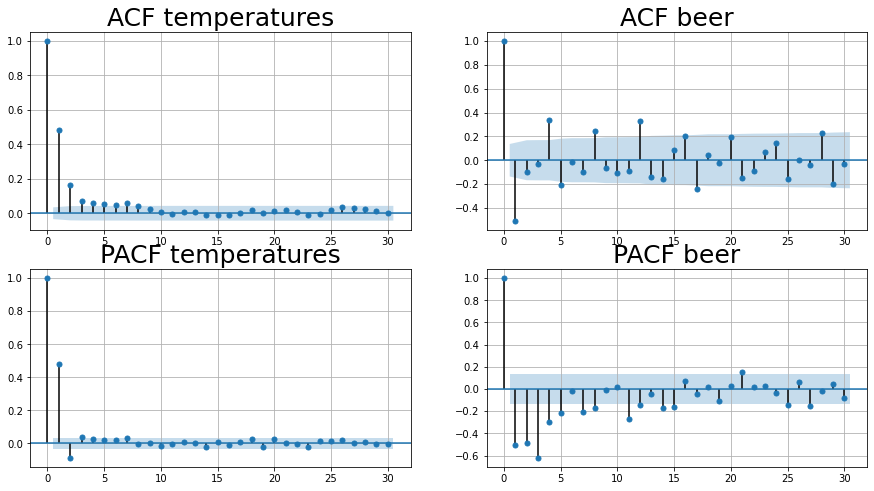

In [20]:
_, ax = plt.subplots(2, 2, figsize=(width, height))

plot_acf(temp_resid.dropna(), lags=30, ax=ax[0][0], title='ACF temperatures'), ax[0][0].grid()
plot_acf(beer_resid.dropna(), lags=30, ax=ax[0][1], title='ACF beer'), ax[0][1].grid()
plot_pacf(temp_resid.dropna(), lags=30, ax=ax[1][0], title='PACF temperatures'), ax[1][0].grid()
plot_pacf(beer_resid.dropna(), lags=30, ax=ax[1][1], title='PACF beer'), ax[1][1].grid()
plt.show()

<span class="text_common"><b>Основные выводы:</b> по графикам ACF и PACF ряд с мининимальными дневными температурами в Австралии действительно похож на стационарный, что касается ряда, характеризуещго продажи пива в Австралии, то его стационарность будет исследована далее.</span>

<h2>Q-тест Льюнга-Бокса</h2>

<span class="text_common"><b>Дано:</b> ряд </span>${\normalsize Y = Y_1, ..., Y_T}$

<span class="text_common"><b>Нулевая гипотеза:</b> ряд </span>${\normalsize Y}$<span class="text_common"> представляет собой белый шум</span>

<span class="text_common"><b>Альтернативная гипотеза:</b> ряд </span>${\normalsize Y}$<span class="text_common"> не являлется белым шумом</span>

<span class="text_common"><b>Статистика критерия:</b></span>
$$
{\large Z = T (T + 2) \sum_{k=1}^{m} { \frac{\hat{\rho}^2_k}{T-k} } }
$$

<span class="text_common">В условиях истинности нулевой гипотезы имеет распределение </span>${\normalsize \chi^2(m) }$

In [21]:
lags = [i for i in range(2, 16)]

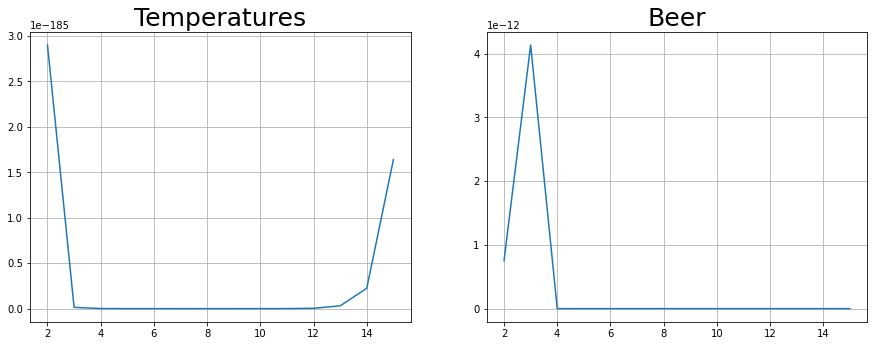

In [22]:
_, ax = plt.subplots(1, 2, figsize=(width, height / 1.5))
ax[0].set_title('Temperatures'), ax[0].grid(), ax[1].set_title('Beer'), ax[1].grid()

ax[0].plot(lags, ljung_box_test(temp_resid.values, lags=lags, return_pvalue=True))
ax[1].plot(lags, ljung_box_test(beer_resid.values, lags=lags, return_pvalue=True))
plt.show()

In [23]:
print_test_results('Льюнга-Бокса', {
    'Temperatures: ': ljung_box_test(temp_resid.values, lags=1, return_pvalue=True),
    'Beer:         ': ljung_box_test(beer_resid.values, lags=1, return_pvalue=True)
})

Тест Льюнга-Бокса. Значения p-value для временных рядов:
Temperatures:  1.664324128835711e-167
Beer:          2.2635004898305e-13


<span class="text_common"><b>Основные выводы:</b> на уровне значимости 5% нельзя считать, что данные ряды представляют собой белый шум.</span>

<h2>Единичный корень</h2>

<span class="text_common"><b>Определение:</b> если имеется процесс, который можно записать как </span>${\normalsize Y_t = a_1 Y_{t-1} + ... + a_p Y_{t-p} + \epsilon_t}$<span class="text_common">, где </span>${\normalsize \epsilon_t}$<span class="text_common"> - случайный процесс с нулевым математическим ожиданием и конечной дисперсией, и если число <b>z</b>, такое, что </span>$|z|=1$<span class="text_common"> является корнем характеристического уравнения </span>${\normalsize 1 - a_1 z - ... - a_p z^p = 0}$<span class="text_common">, то говорят, что процесс </span>${\normalsize Y_t}$<span class="text_common"> имеет <b><i>единичный корень</i></b>.</span>

<h3>Тест Дики-Фуллера</h3>

<span class="text_common"><b>Дано:</b> ряд </span>${\normalsize Y = Y_1, ..., Y_T}$

<span class="text_common"><b>Нулевая гипотеза:</b> ряд </span>${\normalsize Y}$<span class="text_common"> не стационарен</span>

<span class="text_common"><b>Альтернативная гипотеза:</b> ряд </span>${\normalsize Y}$<span class="text_common"> стационарен</span>

<span class="text_common"><b>Статистика критерия:</b></span>
$$
{\large Z = \frac{\tilde{\gamma}}{\sigma[\tilde{\gamma}]}, \ \tilde{\gamma} = OLS(\gamma) }
$$

<span class="text_common">В основе теста лежит следуюзая модель: </span>
$$
{\large Y_t = c + bt + \phi_1 Y_{t-1} + \epsilon_t }
$$

<span class="text_common">В то же время сам тест использует продифференцированную модель: </span>
$$
{\large \Delta Y_t = Y_t - Y_{t-1} = c + bt + \gamma Y_{t-1} + \epsilon_t }
$$

<span class="text_common">В условиях истинности нулевой гипотезы имеет распределение Дики-Фуллера.</span>

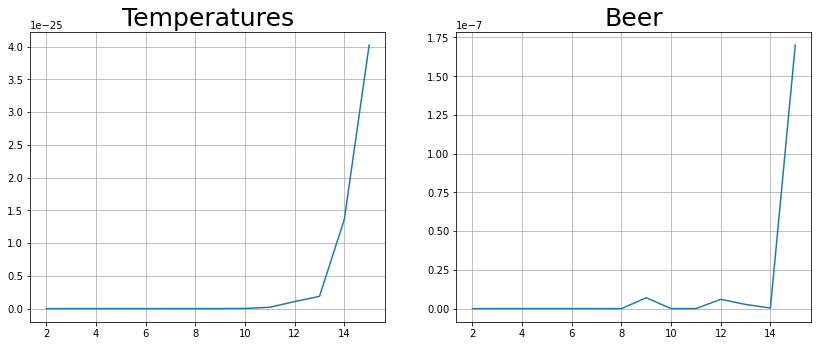

In [24]:
_, ax = plt.subplots(1, 2, figsize=(width-1, height / 1.5))
ax[0].set_title('Temperatures'), ax[0].grid(), ax[1].set_title('Beer'), ax[1].grid()

ax[0].plot(lags, [dickey_fuller_test(temp_resid.values, maxlag=lag, return_pvalue=True) for lag in lags])
ax[1].plot(lags, [dickey_fuller_test(beer_resid.values, maxlag=lag, return_pvalue=True) for lag in lags])
plt.show()

In [25]:
print_test_results('Дики-Фуллера', {
    'Temperatures: ': dickey_fuller_test(temp_resid.values, return_pvalue=True),
    'Beer:         ': dickey_fuller_test(beer_resid.values, return_pvalue=True)
})

Тест Дики-Фуллера. Значения p-value для временных рядов:
Temperatures:  2.7078469688982655e-30
Beer:          3.7533566933975856e-10


<span class="text_common"><b>Основные выводы:</b> на уровне значимости 5% оба ряда могут считаться стационарными.</span>

<h3>Тест KPSS</h3>

<span class="text_common"><b>Дано:</b> ряд </span>${\normalsize Y = Y_1, ..., Y_T}$

<span class="text_common"><b>Нулевая гипотеза:</b> ряд </span>${\normalsize Y}$<span class="text_common"> стационарен</span>

<span class="text_common"><b>Альтернативная гипотеза:</b> ряд </span>${\normalsize Y}$<span class="text_common"> описывается моделью </span>${\normalsize Y_t = \alpha Y_{t-1} + \epsilon_t}$

<span class="text_common"><b>Статистика критерия:</b></span>
$$
{\large Z = \frac{1}{T^2} \sum_{i=1}^{T} {\left( \sum_{t=1}^{i} {Y_t} \right)^2} \big / \lambda^2 }
$$

<span class="text_common">В условиях истинности нулевой гипотезы имеет табличное распределение.</span>

In [26]:
lags = [i for i in range(2, 150)]

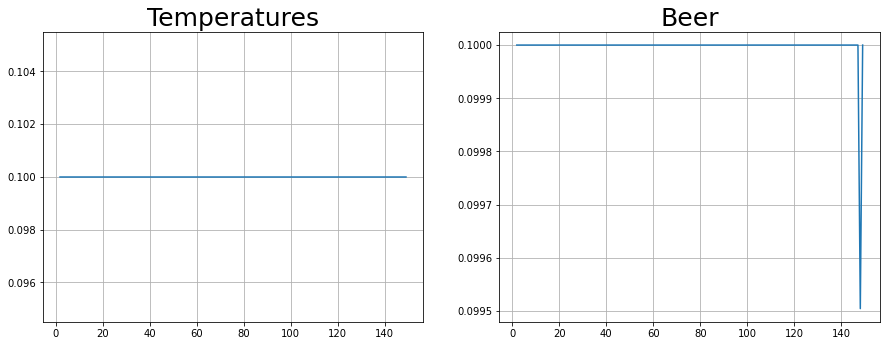

In [27]:
_, ax = plt.subplots(1, 2, figsize=(width, height / 1.5))
ax[0].set_title('Temperatures'), ax[0].grid(), ax[1].set_title('Beer'), ax[1].grid()

ax[0].plot(lags, [kpss_test(temp_resid.values, lags=lag, return_pvalue=True) for lag in lags])
ax[1].plot(lags, [kpss_test(beer_resid.values, lags=lag, return_pvalue=True) for lag in lags])
plt.show()

In [28]:
print_test_results('KPSS', {
    'Temperatures: ': kpss_test(temp_resid.values, return_pvalue=True),
    'Beer:         ': kpss_test(beer_resid.values, return_pvalue=True)
})

Тест KPSS. Значения p-value для временных рядов:
Temperatures:  0.1
Beer:          0.1


<span class="text_common"><b>Основные выводы:</b> на уровне значимости 5% оба ряда могут считаться стационарными.</span>

<h3>Примеры</h3>

<span class="text_common">Если процесс имеет единичный корень, то он не является стационарным. В качестве примера можно рассмотреть следующий процесс: </span>${\normalsize Y_t = Y_{t-1} + \epsilon_t}$<span class="text_common">, несложно увидеть, что данный процесс имеет единичный корень, а так же дисперсия процесса зависит от времени: </span>${\normalsize D[Y_t] = t \sigma^2}$

In [29]:
noise = scipy.stats.norm(loc=0, scale=1)

In [30]:
process = [0]
for i in range(500):
    process.append(process[-1] + noise.rvs(random_state=i))

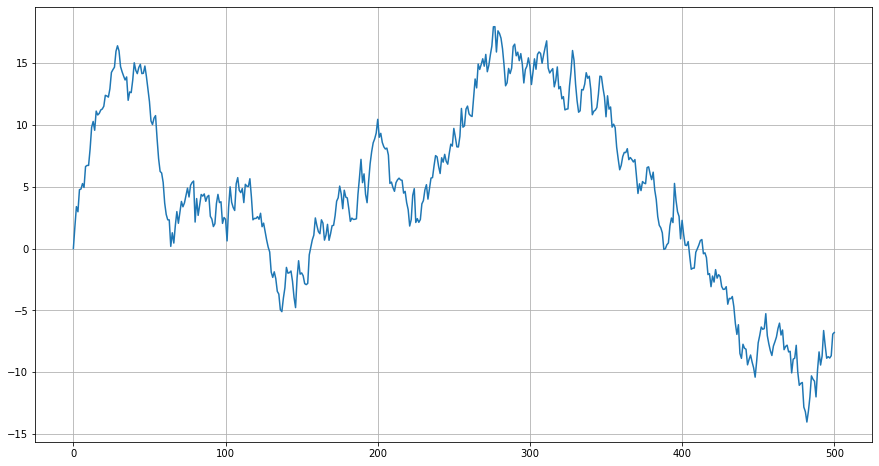

In [31]:
plt.plot(process)
plt.grid()

In [32]:
dickey_fuller_test(process)
kpss_test(process)

Тест Дики-Фуллера: ряд нестационарный
Тест KPSS: ряд нестационарный


<span class="text_common"><b>Основные выводы:</b> на графике заметно, что дисперсия действительно зависит от времени, а сам ряд, очевидно, стационарным не является, о чем нам говорят статистические тесты.</span>

In [33]:
process_diff = [process[i] - process[i-1] for i in range(1, len(process))]

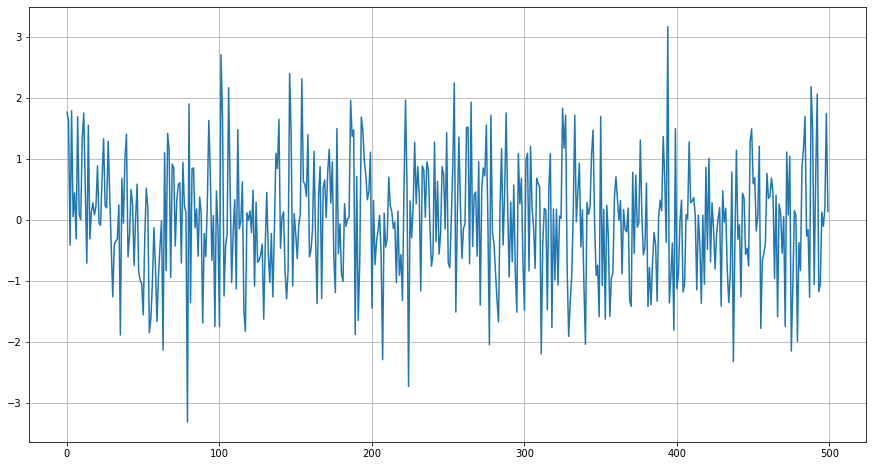

In [34]:
plt.plot(process_diff)
plt.grid()

In [35]:
dickey_fuller_test(process_diff)
kpss_test(process_diff)

Тест Дики-Фуллера: ряд стационарный
Тест KPSS: ряд стационарный


<span class="text_common"><b>Основные выводы:</b> так как процесс имеет единичный корень кратности 1, то продифференцированный ряд является стационарным, что видно по графику и по результатам тестов.</span>

<span class="text_common">Рассмотрим теперь процесс с единичным корнем кратности 2: </span>${\normalsize Y_t = 2 Y_{t-1} - Y_{t-2} + \epsilon_t}$

In [36]:
process = [0, 0]
for i in range(500):
    process.append(2 * process[-1] - process[-2] + noise.rvs(random_state=i*i))

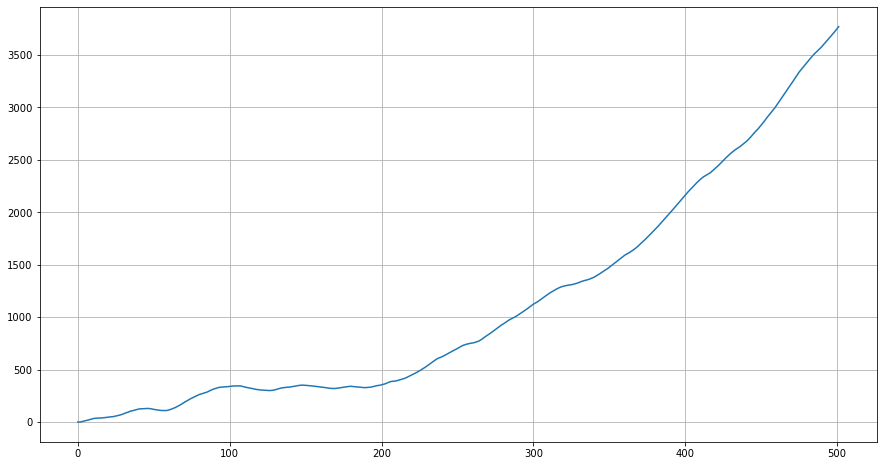

In [37]:
plt.plot(process)
plt.grid()

In [38]:
dickey_fuller_test(process)
kpss_test(process)

Тест Дики-Фуллера: ряд нестационарный
Тест KPSS: ряд нестационарный


<span class="text_common"><b>Основные выводы:</b> ожидаемо такой ряд стационарным процессом не является.</span>

In [39]:
process_diff = [process[i] - process[i-1] for i in range(1, len(process))]

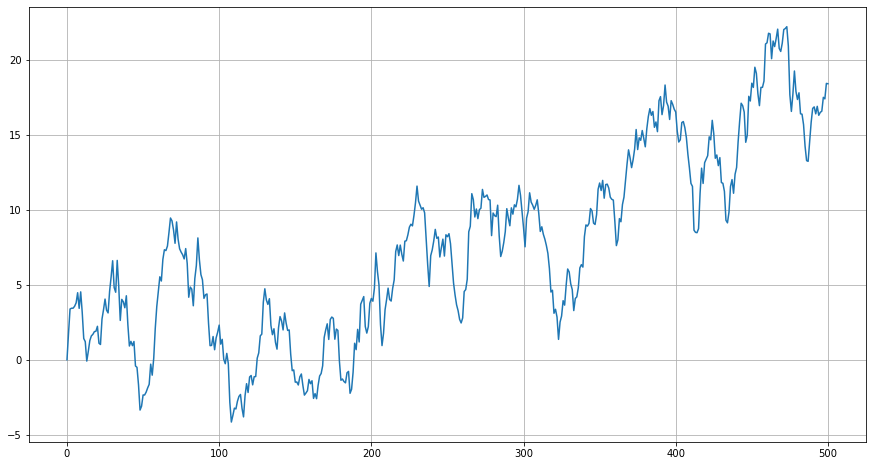

In [40]:
plt.plot(process_diff)
plt.grid()

In [41]:
dickey_fuller_test(process_diff)
kpss_test(process_diff)

Тест Дики-Фуллера: ряд нестационарный
Тест KPSS: ряд нестационарный


<span class="text_common"><b>Основные выводы:</b> так как процесс имеет единичный корень кратности 2, то продифференцированный ряд не должен являться стационарным, что видно по графику и по результатам тестов.</span>

In [42]:
process_2nd_diff = [process_diff[i] - process_diff[i-1] for i in range(1, len(process_diff))]

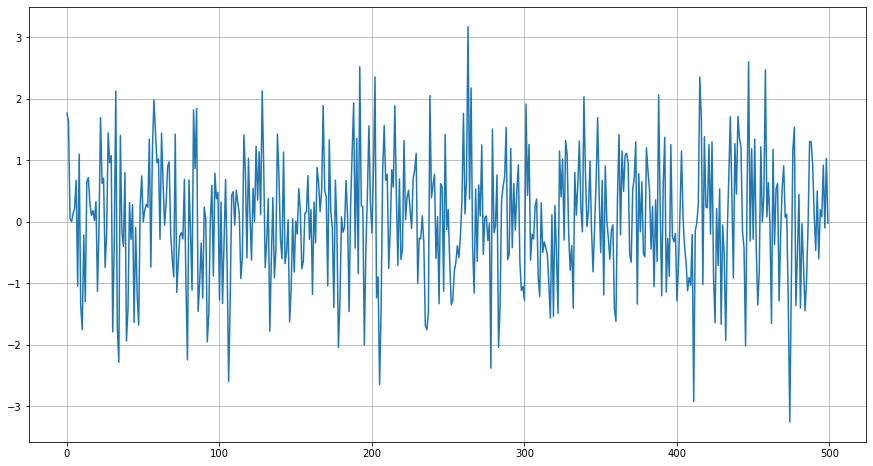

In [43]:
plt.plot(process_2nd_diff)
plt.grid()

In [44]:
dickey_fuller_test(process_2nd_diff)
kpss_test(process_2nd_diff)

Тест Дики-Фуллера: ряд стационарный
Тест KPSS: ряд стационарный


<span class="text_common"><b>Основные выводы:</b> вторая производная ряда является стационарным процессом. Это было ожидаемо вследствие двойной кратности единичного корня характеристического полинома ряда.</span>

<h1>Моделирование стохастической компоненты</h1>
<h2>Определение параметров ARMA-модели</h2><br>
<span class="text_common">Использовать будем временной ряд с объемами продажи пива в Австралии. Постороим его стохастическую компоненту и графики автокорреляционных функций.</span>

In [45]:
data = temp_resid.diff().dropna()

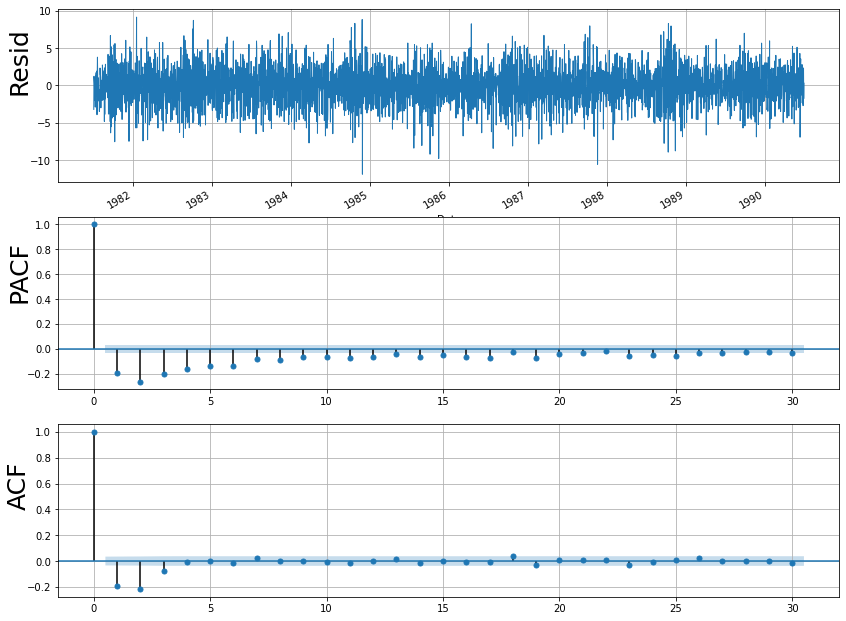

In [46]:
_, ax = plt.subplots(3, 1, figsize=(width-1, height * 1.5))

data.plot(ax=ax[0], linewidth=1)
plot_pacf(data, lags=30, ax=ax[1])
plot_acf(data, lags=30, ax=ax[2])

ax[0].set_title('Resid', rotation='vertical', x=-0.05, y=0.5)
ax[1].set_title('PACF',  rotation='vertical', x=-0.05, y=0.5)
ax[2].set_title('ACF',   rotation='vertical', x=-0.05, y=0.5)

for x in ax: x.grid()
plt.show()

<span class="text_common"><b>Основные выводы:</b> p = 5, q = 4</span>

<h2>Построение ARMA-модели</h2><br>
<span class="text_common">Построим несколько моделей ARMA с разными параметрами <b>p</b> и <b>q</b>. После этого из них выберем лучшую по критерию Акаике и по байесовскому информационному критерию. Их значения изобразим на двумерной поверхности в пространстве.</span>

In [47]:
models_file = './data/models.pickle'

In [48]:
# Построение всех моделей - дело долгое, так что можно загружать сериализованные
# ARMA(2, 4) и ARMA(4, 2) не строятся :(
models = build_models(ARMA, data,
    (2, 1), (2, 2), (2, 3),
    (3, 1), (3, 2), (3, 3), (3, 5),
    (4, 1),         (4, 3), (4, 5),
    (5, 1), (5, 2), (5, 4), (5, 5),
    file=models_file)

Loading models from ./data/models.pickle...
Load success


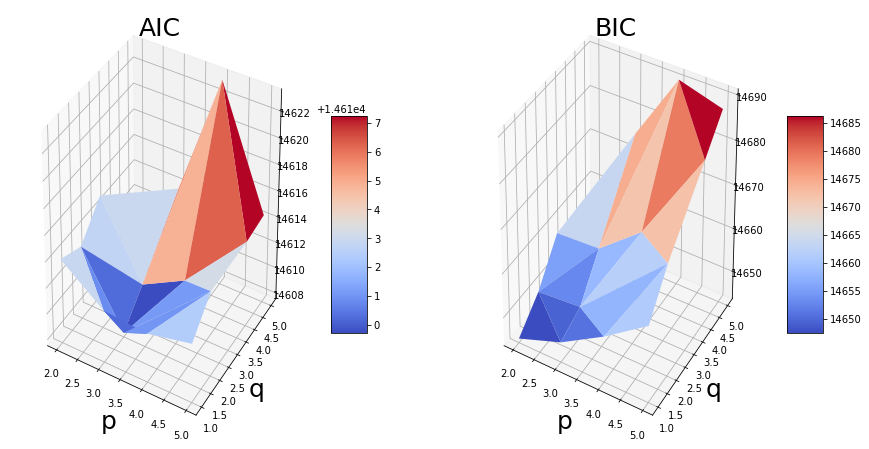

In [49]:
# Подготовим данные для графиков и построим графики AIC и BIC
fig = plt.figure()
ax = (
    fig.add_subplot(1, 2, 1, projection='3d'),
    fig.add_subplot(1, 2, 2, projection='3d'),
)

filterwarnings('ignore')
points_aic = scipy.array([(params[0], params[1], model.aic) for params, model in models.items()])
points_bic = scipy.array([(params[0], params[1], model.bic) for params, model in models.items()])
filterwarnings('default')

s1 = ax[0].plot_trisurf(points_aic[:,0], points_aic[:,1], points_aic[:,2], cmap=cm.coolwarm)
s2 = ax[1].plot_trisurf(points_bic[:,0], points_bic[:,1], points_bic[:,2], cmap=cm.coolwarm)

fig.colorbar(s1, shrink=0.5, aspect=6, ax=ax[0])
fig.colorbar(s2, shrink=0.5, aspect=6, ax=ax[1])

ax[0].set_title('AIC'), ax[1].set_title('BIC')
ax[0].set_xlabel('p', size=25), ax[0].set_ylabel('q', size=25)
ax[1].set_xlabel('p', size=25), ax[1].set_ylabel('q', size=25)

plt.show()

In [50]:
print('Best by AIC: ', get_best_model(points_aic))
print('Best by BIC: ', get_best_model(points_bic))

Best by AIC:  (3, 2)
Best by BIC:  (2, 1)


<span class="text_common"><b>Основные выводы:</b> по значениям AIC можно заключить, что оптимальной моделью является ARMA(3, 2), а по BIC - ARMA(2, 1). Выберем первую и попробуем уменьшить p и q на 1, производя LR тест.</span>

In [51]:
ARMAOptimal = models[(3, 2)]

<span class="text_common">Попробуем уменьшить порядок модели. Сначала уменьшим порядок <b>p</b> на 1.</span>

In [52]:
ARMACandidate = models[(2, 2)]
likelyhood_ratio_test(ARMAOptimal, ARMACandidate, verbose=True)

LR тест: значения отличаются значительно
Статистика критерия:	7.294575486665053
p-value:		0.0069163109834021195


<div class="text_common"><b>Основные выводы:</b> LR-тест показывает, что соответствие модели данным меняется достаточно сильно, а значит модель менять не будем.</div>

<span class="text_common">Теперь уменьшим порядок <b>q</b> на 1.</span>

In [53]:
ARMACandidate = models[(3, 1)]
likelyhood_ratio_test(ARMAOptimal, ARMACandidate, verbose=True)

LR тест: значения отличаются значительно
Статистика критерия:	5.673162275656068
p-value:		0.017226375469434476


<span class="text_common"><b>Основные выводы:</b> LR-тест показывает, что соответствие модели данным меняется достаточно сильно, а значит модель менять не будем.</span>

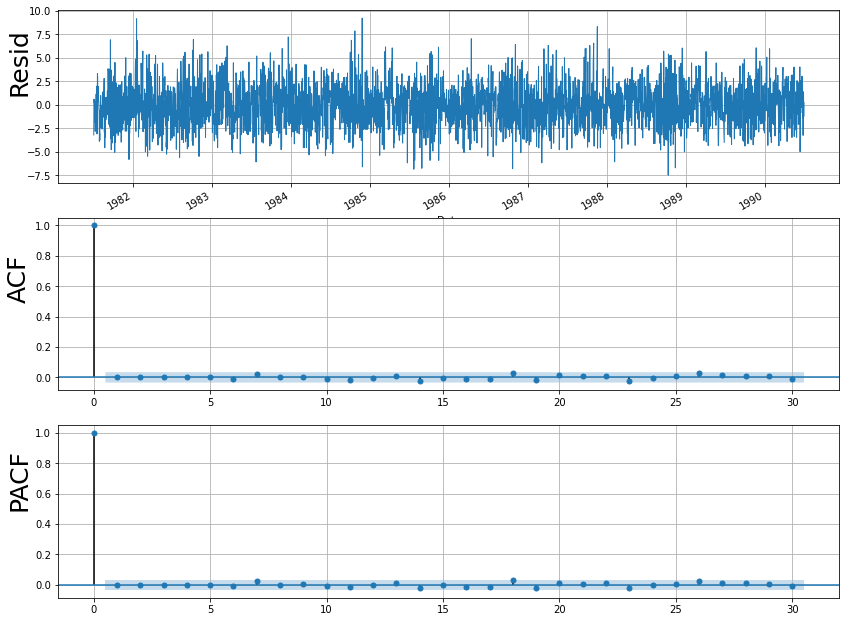

In [54]:
_, ax = plt.subplots(3, 1, figsize=(width-1, height * 1.5))

ARMAOptimal.resid.plot(ax=ax[0], linewidth=1)
plot_acf(ARMAOptimal.resid, lags=30, ax=ax[1])
plot_pacf(ARMAOptimal.resid, lags=30, ax=ax[2])

ax[0].set_title('Resid', rotation='vertical', x=-0.05, y=0.5)
ax[1].set_title('ACF',   rotation='vertical', x=-0.05, y=0.5)
ax[2].set_title('PACF',  rotation='vertical', x=-0.05, y=0.5)

for x in ax: x.grid()
plt.show()

<span class="text_common"><b>Основные выводы:</b> график остатков выглядит как случайный шум, графики же ACF и PACF показывают, что значимые автокорреляции между значениями остатков отсутствуют.</span>

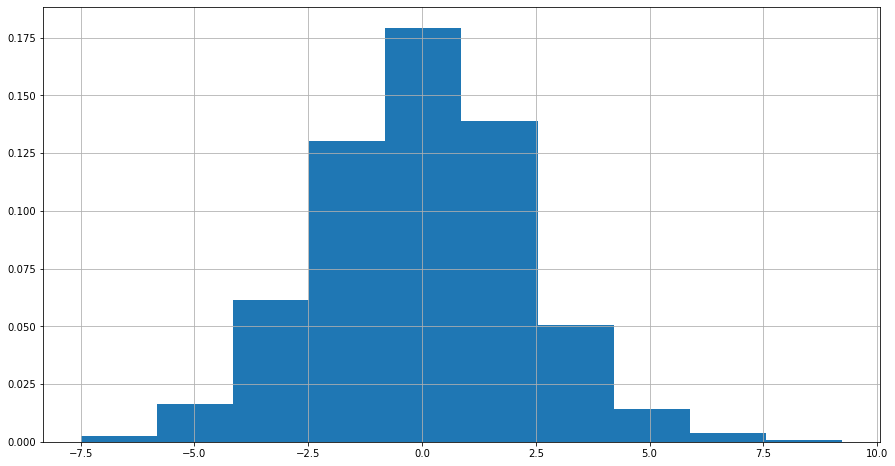

In [55]:
ARMAOptimal.resid.hist(density=True)
plt.show()

<span class="text_common"><b>Основные выводы:</b> распределение отстатков, судя по гистограмме, похоже на нормальное.</span>

In [56]:
jarque_bera_test(ARMAOptimal.resid, verbose=True)

Тест Харке-Бера: значения не имеют нормальное распределение
Статистика критерия:	14.531152160873908
p-value:		0.0006991983591095874


In [57]:
ljung_box_test(ARMAOptimal.resid, verbose=True)

Тест Льюнга-Бокса: ряд является слабым белым шумом
Статистика критерия:	1.2109051864031724e-05
p-value:		0.9972235218845297


<span class="text_common"><b>Основные выводы:</b> Q-тест Льюнга-Бокса говорит о том, что ряд остатков представляет собой белый шум, в то же время тест Харке-Бера показывает, что распределение величины не является нормальным - это ошибка 1 рода.</span>